In [130]:
%pip install setuptools
%pip install ydata_profiling
%pip install scikit-learn
%pip install xlrd
%pip install openpyxl
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [131]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from ydata_profiling import ProfileReport
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [132]:
excel_data_volumes=pd.read_excel("././dataset/Объёмы перевозок.xls", skiprows=[0], header=[0,1])

In [133]:
print("Количество пропущенных значений:")
print(excel_data_volumes.isnull().sum())

Количество пропущенных значений:
Unnamed: 0_level_0  ID                        0
Unnamed: 1_level_0  Субъект федерации отп     0
Unnamed: 2_level_0  Субъект федерации наз     0
Unnamed: 3_level_0  Код груза                 0
Месяц               Гр груза по опер.номен    0
                                             ..
2024/08             Объем перевозок(тн)       0
2022/01             Провозная плата           0
                    Объем перевозок(тн)       0
2023/07             Провозная плата           0
                    Объем перевозок(тн)       0
Length: 69, dtype: int64


In [134]:
excel_data_volumes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13425 entries, 0 to 13424
Data columns (total 69 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   (Unnamed: 0_level_0, ID)                     13425 non-null  int64 
 1   (Unnamed: 1_level_0, Субъект федерации отп)  13425 non-null  object
 2   (Unnamed: 2_level_0, Субъект федерации наз)  13425 non-null  object
 3   (Unnamed: 3_level_0, Код груза)              13425 non-null  int64 
 4   (Месяц, Гр груза по опер.номен)              13425 non-null  object
 5   (2022/08, Провозная плата)                   13425 non-null  int64 
 6   (2022/08, Объем перевозок(тн))               13425 non-null  int64 
 7   (2023/10, Провозная плата)                   13425 non-null  int64 
 8   (2023/10, Объем перевозок(тн))               13425 non-null  int64 
 9   (2024/01, Провозная плата)                   13425 non-null  int64 
 10  (2024/01, 

In [135]:
excel_data_volumes.sort_index(axis=1, inplace=True)
num_col=len(excel_data_volumes.columns)
left = excel_data_volumes.iloc[:, [num_col-5, num_col-4, num_col-3, num_col-2,num_col-1]]
left.columns = left.columns.get_level_values(1)
left = left.set_axis(["id", "subj_from", "subj_to", "cargo_code", "cargo_type"], axis = 1)
labelencodder = LabelEncoder()
left.loc[:, ["subj_from"]] = labelencodder.fit_transform(left["subj_from"])
left.loc[:, ["subj_to"]] = labelencodder.fit_transform(left["subj_to"])
left.loc[:, ["cargo_type"]] = labelencodder.fit_transform(left["cargo_type"])
left

,id,subj_from,subj_to,cargo_code,cargo_type
0,21220,8,36,39146,13
1,912,1,58,32411,36
2,912,1,40,32411,36
3,912,1,69,32411,36
4,912,1,36,32411,36
...,...,...,...,...,...
13420,11274,7,55,24116,20
13421,20123,10,36,32411,36
13422,20123,10,0,32411,36
13423,20123,10,73,32411,36


In [136]:
for i in range(int((num_col-5)/2)):
    right = excel_data_volumes.iloc[:, [i*2,i*2+1]]
    date = pd.to_datetime(excel_data_volumes.iloc[:, [i*2]].columns.get_level_values(0).to_list()[0], format="%Y/%m")
    right.insert(2, ("", "date"), date)
    right.columns = right.columns.get_level_values(1)
    right = right.set_axis(["cargo_volume", "cargo_price", "date"], axis=1)
    if i == 0:
        result = pd.concat([left, right], axis = 1, sort = False)
    else:
        result = pd.concat([result, pd.concat([left, right], axis = 1, sort = False)], axis = 0, ignore_index=True, sort=False)
excel_data_volumes = result
excel_data_volumes.loc[excel_data_volumes["id"] == 912]

,id,subj_from,subj_to,cargo_code,cargo_type,cargo_volume,cargo_price,date
1,912,1,58,32411,36,0,0,2022-01-01
2,912,1,40,32411,36,476,1440050,2022-01-01
3,912,1,69,32411,36,0,0,2022-01-01
4,912,1,36,32411,36,0,0,2022-01-01
5,912,1,36,32102,36,0,0,2022-01-01
...,...,...,...,...,...,...,...,...
416228,912,1,38,32411,36,0,0,2024-08-01
416229,912,1,51,32411,36,0,0,2024-08-01
416230,912,1,31,32411,36,0,0,2024-08-01
416231,912,1,1,32411,36,0,0,2024-08-01


In [137]:
data_pd = excel_data_volumes.groupby(["id", "date"], as_index=False).sum()
data_pd = data_pd.drop(data_pd.iloc[:, [2, 3, 4, 5]], axis=1)
data_pd["innactive"] = data_pd.apply(lambda x: 1 if ((x["cargo_volume"] == 0) & (x["cargo_price"] == 0)) else 0, axis=1)
data_pd["active"] = data_pd.apply(lambda x: 1 if ((x["cargo_volume"] > 0) & (x["cargo_price"] > 0)) else 0, axis=1)

data_pd["outflow"] = 0

def calc_innactive(row):
    prev_row_value = 0
    row_value = data_pd.iloc[row.name]["innactive"]
    row_id = data_pd.iloc[row.name]["id"]
    if row.name > 0:
        prev_row_id = data_pd.iloc[row.name - 1]["id"]
        if row_id == prev_row_id:
            if  row_value > 0:
                prev_row_value = data_pd.iloc[row.name - 1]["innactive"]
                data_pd.iloc[row.name, data_pd.columns.get_loc("innactive")] = prev_row_value + 1
                row_value = data_pd.iloc[row.name]["innactive"]
                if row_value > 11:
                    prev_row_value = 1
                else:
                    prev_row_value = row_value/12
            else: 
                prev_row_value = 0
    return prev_row_value

def calc_active(row):
    row_value = data_pd.iloc[row.name]["active"]
    row_id = data_pd.iloc[row.name]["id"]
    if row.name > 0:
        prev_row_id = data_pd.iloc[row.name - 1]["id"]
        if row_id == prev_row_id:
            if  row_value > 0:
                prev_row_value = data_pd.iloc[row.name - 1]["active"]
                data_pd.iloc[row.name, data_pd.columns.get_loc("active")] = prev_row_value + 1
    return 0

data_pd["outflow"] = data_pd.apply(calc_innactive, axis=1)
data_pd["innactive"] = data_pd.apply(lambda x: 1 if ((x["cargo_volume"] == 0) & (x["cargo_price"] == 0)) else 0, axis=1)
# data_pd.apply(calc_active, axis=1)
data_pd

,id,date,cargo_volume,cargo_price,innactive,active,outflow
0,9,2022-01-01,0,0,1,0,0.000000
1,9,2022-02-01,0,0,1,0,0.166667
2,9,2022-03-01,0,0,1,0,0.250000
3,9,2022-04-01,0,0,1,0,0.333333
4,9,2022-05-01,0,0,1,0,0.416667
...,...,...,...,...,...,...,...
30587,21729,2024-04-01,73,301863,0,1,0.000000
30588,21729,2024-05-01,0,0,1,0,0.083333
30589,21729,2024-06-01,0,0,1,0,0.166667
30590,21729,2024-07-01,0,0,1,0,0.250000


In [138]:
fit = data_pd
# fit.to_excel("output.xlsx")
l = fit.drop(labels="date", axis=1).groupby(["id"]).sum().apply(lambda x: x)
r = fit.drop(labels="date", axis=1).groupby(["id"]).outflow.last().apply(lambda x: x).rename("out")

fit_pd = pd.concat([l, r], axis=1).drop("outflow", axis=1)
fit_pd["out"] = fit_pd.apply(lambda x: 1 if (x["out"] == 1) else 0, axis=1).astype("int64")
fit_pd["active"] = fit_pd.apply(lambda x: x["active"]/(x["active"]+x["innactive"]), axis=1)
fit_pd["cargo_price_volume"] = fit_pd.apply(lambda x: x["cargo_price"]/x["cargo_volume"], axis=1)
fit_pd = fit_pd.drop(labels="innactive", axis=1).drop(labels="cargo_price", axis=1).drop(labels="cargo_volume", axis=1)
fit_pd

,active,out,cargo_price_volume
id,,,
9,0.12500,0,3073.967593
25,1.00000,0,450.236991
33,1.00000,0,2938.171106
86,0.09375,1,1693.483774
115,1.00000,0,2402.412224
...,...,...,...
21725,0.06250,0,2516.666667
21726,0.06250,0,3024.348361
21727,0.03125,0,2809.680176


In [139]:
ProfileReport(fit_pd, minimal = True) # Формирование отчета для исследования данных

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [140]:
fit_pd.mean() # расчет средних значений признаков для тех кто ушел и остался

active                   0.461629
out                      0.260460
cargo_price_volume    3184.564701
dtype: float64

In [141]:
fit_pd.groupby(by = "out").mean() # расчет средних значений признаков для тех кто ушел и остался

,active,cargo_price_volume
out,,
0,0.579878,3068.446425
1,0.125879,3514.265991


<Axes: >

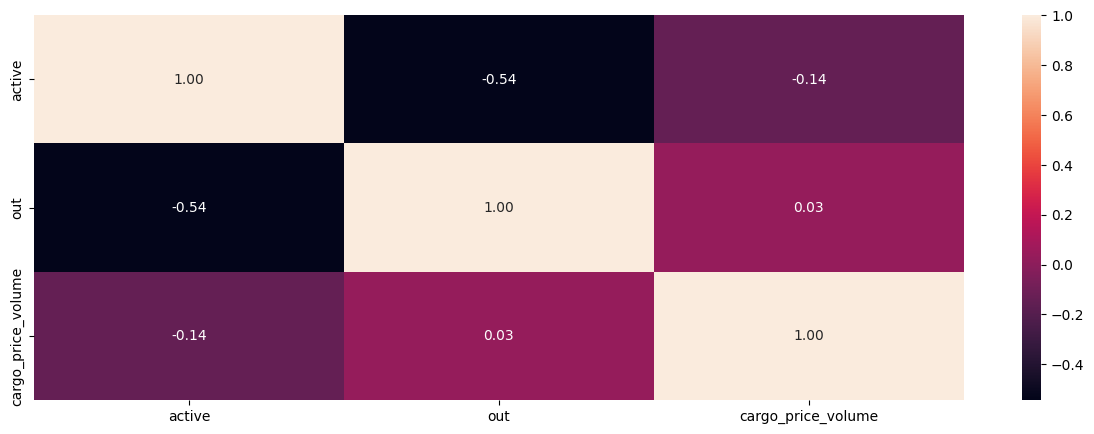

In [142]:
cor = fit_pd.corr() # матрица корреляций
fig, ax = plt.subplots(figsize=(15,5)) 
sns.heatmap(cor, annot = True, fmt = ".2f") # тепловая карта на основе матрицы корреляций

In [145]:
X = fit_pd.drop("out", axis = 1)
y=fit_pd["out"] # разделение данных на признаки (матрица X) и целевую переменную (y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0) # разделение модели на обучающую и валидационную выборку

model = LogisticRegression(max_iter = 1000)  
model.fit(X_train,y_train)
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, predictions)
precision = precision_score (y_test, predictions)
recall = recall_score (y_test, predictions)
print(acc, precision, recall) # вывод на экран метрик, характеризующих качество модели


0.7864583333333334 0.64 0.5818181818181818


In [146]:
rf_model = RandomForestClassifier(n_estimators = 100)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test) 
acc_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score (y_test, y_pred)
recall_rf = recall_score (y_test, y_pred)
print(acc_rf, precision_rf, recall_rf)# вывод на экран метрик, характеризующих качество модели

0.7760416666666666 0.6363636363636364 0.509090909090909


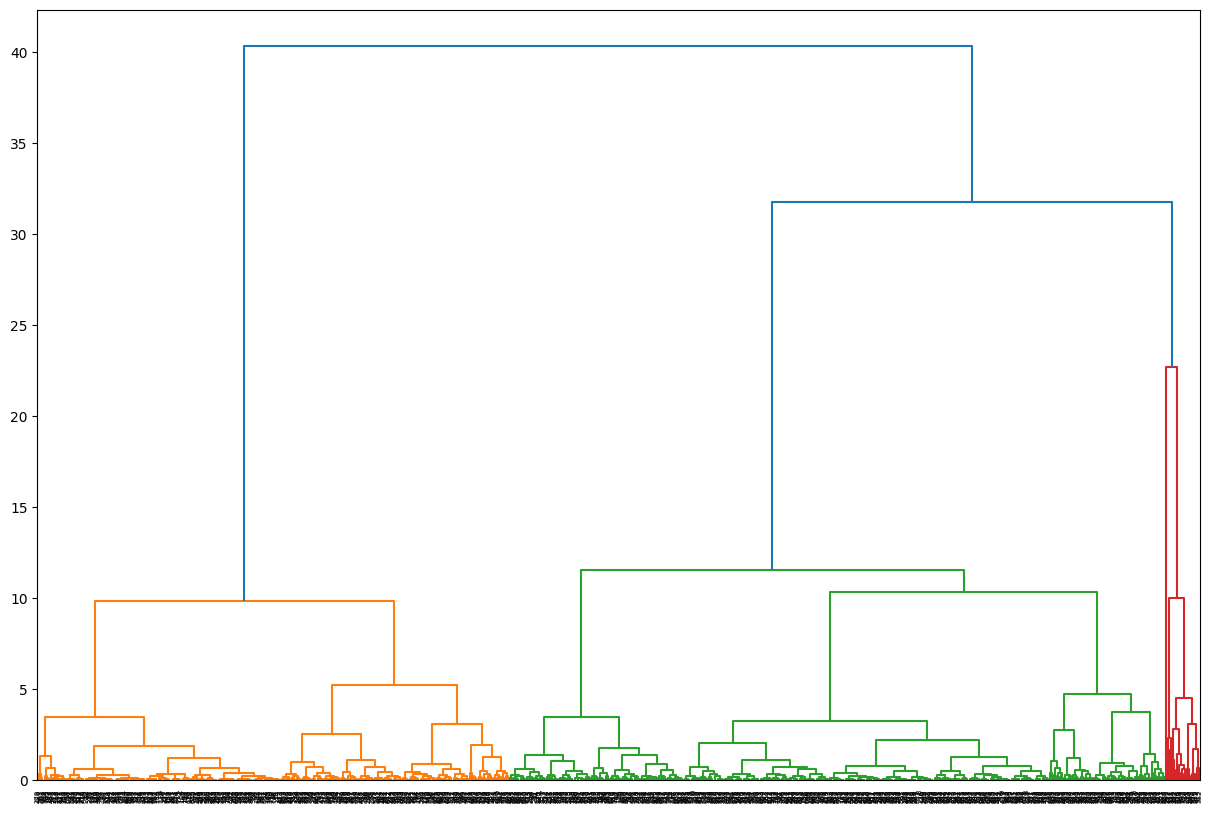

In [147]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = "ward")
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation="top")
plt.show() # вывод на экран дендрограммы

In [148]:
cl = 3 # количество кластеров выбранов соответствии с дендрограммой, а также на основе анализа нескольких вариантов
km = KMeans(n_clusters = cl)
labels = km.fit_predict(X_sc)

In [149]:
fit_pd["claster"]= labels # добавление колонки с категориями

In [150]:
piv = pd.pivot_table(data = fit_pd, index = "claster", columns = "out", values = "active", aggfunc = "count" ).reset_index() # формирование сводной таблицы для анализа оттока по категориям
piv.columns = ["claster","out_0","out_1"]
piv["perc"] = piv["out_1"]/(piv["out_0"]+piv["out_1"])
piv["number"]=piv["out_1"]+piv["out_0"]
print(piv.head())

   claster  out_0  out_1      perc  number
0        0    394      4  0.010050     398
1        1    294    238  0.447368     532
2        2     19      7  0.269231      26


<Axes: >

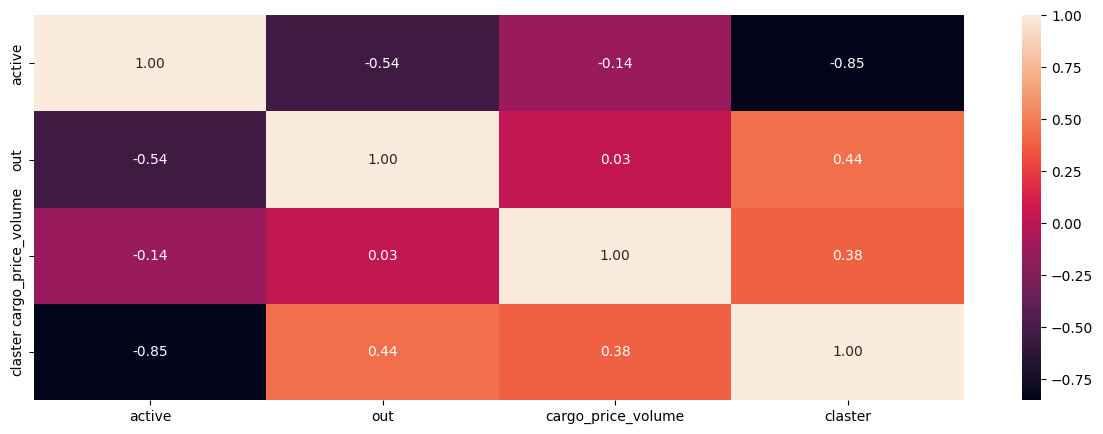

In [151]:
cor = fit_pd.corr()
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(cor, annot = True, fmt = ".2f")

In [152]:
fit_pd

,active,out,cargo_price_volume,claster
id,,,,
9,0.12500,0,3073.967593,1
25,1.00000,0,450.236991,0
33,1.00000,0,2938.171106,0
86,0.09375,1,1693.483774,1
115,1.00000,0,2402.412224,0
...,...,...,...,...
21725,0.06250,0,2516.666667,1
21726,0.06250,0,3024.348361,1
21727,0.03125,0,2809.680176,1
